In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

In [2]:
#the newer version of cv2 does not contain SIFT and SURF. So we need to downgrade cv2
# Uncomment the following lines the first time the code is run

#!pip install opencv-python==3.4.2.16
#!pip install opencv-contrib-python==3.4.2.16

# SIFT

In [3]:
#get the keypoints and descriptors of the two images using SIFT.
def get_sift_keypoints(image1,image2):
  im1=cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
  im2=cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

  sift = cv2.xfeatures2d.SIFT_create(nfeatures=1000,sigma=1.4)  #nOctaveLayers=5,contrastThreshold=0.1,edgeThreshold=10,sigma=1.4 can use these arguments as well
  keypoints_sift1, descriptors1 = sift.detectAndCompute(im1, None)
  keypoints_sift2, descriptors2 = sift.detectAndCompute(im2, None)

  img = cv2.drawKeypoints(image1, keypoints_sift1, None)
  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.imshow(img)
  img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
  cv2.imwrite("kp1.JPG",img)

  img = cv2.drawKeypoints(image2, keypoints_sift2, None)
  plt.subplot(1,2,2)
  plt.imshow(img)
  img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
  cv2.imwrite("kp2.JPG",img)

  return keypoints_sift1,keypoints_sift2,descriptors1,descriptors2

In [4]:
######################################################
def SSD(des1, des2):
    #define ssd metric as the sum of squared differences. to keep values from blowing out we take root of the distance.
    return (np.sum((des1-des2)**2))


def Correspondence(des1, des2, kp1, kp2): #(#,128), (##,128), 
    #find correspondence between two images using ssd metric
    n1=des1.shape[0]
    n2=des2.shape[0]
    dist=[]   # distance between every descriptor
    points=[] # best match points
    for i in range(n1):
        ssd = np.array([SSD(des1[i,:], des2[j,:]) for j in range(n2)]) #send descriptors to ssd to compute distances
        #print(dist)
        j = np.argmin(ssd)
        dist.append(np.min(ssd))
        points.append((i,j))
        
    # Select 100 pairs to eliminate outliers
    BestPairs = [x for _,x in sorted(zip(dist,points))]  # Incresing order  
    SelectedPairs = BestPairs[0:int(np.min([100,len(BestPairs)]))] 
    int_corrs = np.zeros((len(SelectedPairs), 4))
    kp1_xy_corrs = np.asarray([(kp1[i].pt[0],kp1[i].pt[1]) for i, _ in SelectedPairs])
    kp2_xy_corrs = np.asarray([(kp2[j].pt[0],kp2[j].pt[1]) for _, j in SelectedPairs])
    return np.concatenate((kp1_xy_corrs,kp2_xy_corrs),axis=1)

In [135]:
im1 = cv2.imread('/content/drive/MyDrive/hw5/5.jpeg')
im2 = cv2.imread('/content/drive/MyDrive/hw5/4.jpeg')
im3 = cv2.imread('/content/drive/MyDrive/hw5/3.jpeg')
im4 = cv2.imread('/content/drive/MyDrive/hw5/2.jpeg')
im5 = cv2.imread('/content/drive/MyDrive/hw5/1.jpeg')


im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
im4 = cv2.cvtColor(im4, cv2.COLOR_BGR2RGB)
im5 = cv2.cvtColor(im5, cv2.COLOR_BGR2RGB)

Number of detected correspondences:  100


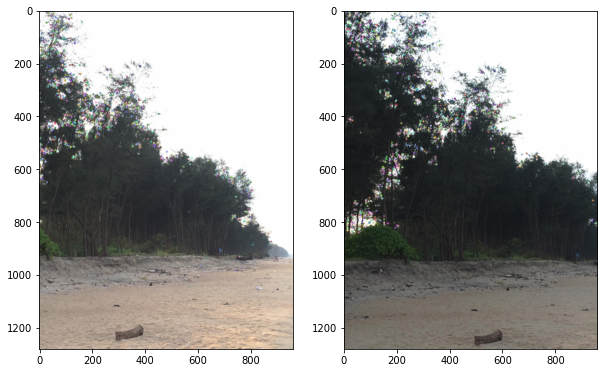

In [119]:
kp1,kp2,des1,des2=get_sift_keypoints(im4,im5)
cor1=Correspondence(des1,des2,kp1,kp2)
print("Number of detected correspondences: ",len(cor1))

In [120]:
def DrawPairs(input_image1, input_image2, Corres):
    # function to draw lines in the two images to highlight correspondence
    left =input_image1
    right = input_image2
    output = np.concatenate((left, right), axis = 1) # (800, 1200, 3)
    for idx in range(Corres.shape[0]):
        w1 = int(Corres[idx,0])   # x-coordinate of image 1
        h1 = int(Corres[idx,1])   # y coordinate of image 1
        w2 = int(Corres[idx,2] + left.shape[1]) # x coordinate of image 2 (add image1 width to get points in image 2 plane)
        h2 = int(Corres[idx,3])   #y coordinate of image 2
        cv2.line(output, (w1,h1),(w2,h2), (0,0,255), 2)  # draw corresponding lines
        plt.imshow(output.astype(int))
    output = cv2.cvtColor(output,cv2.COLOR_RGB2BGR)
    cv2.imwrite("pair_image.jpg", output)

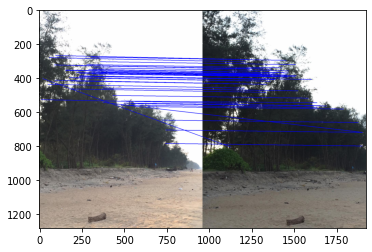

In [121]:
DrawPairs(im4,im5,cor1[:50,:])

# Linear Least Squares (LLS)

In [123]:
def LLS(p1,p2):
# This function is used to determine the Homography between two images using Least Squares algorithm.

    H = np.zeros((3,3),dtype = np.float) #initialize H matrix

    # we will use svd to find the elements of H matrix. A matrix will be a (2n x 9) matrix which will be decomposed
    A = np.zeros((len(p1)*2,9))

    #get the elements of the A matrix (homework 2)
    for i in range(len(p1)):
        A[i*2]=[0, 0, 0, -p1[i,0], -p1[i,1], -1, p2[i,1]*p1[i,0], p2[i,1]*p1[i,1], p2[i,1]]
        A[i*2+1]=[p1[i,0], p1[i,1], 1, 0, 0, 0, -p2[i,0]*p1[i,0], -p2[i,0]*p1[i,1],-p2[i,0]]
        
    # Find SVD decomposition of A matrix          
    U,D,Vt = np.linalg.svd(A)      
    V = np.transpose(Vt) #Need to take transpose because rows of V are eigen vectors
    H_elements = V[:,-1] #Last column is the solution as we need to minimize the least squares
    
    #Fill the Homography Matrix - divide by the last element 
    H[0] = H_elements[0:3] / H_elements[-1]
    H[1] = H_elements[3:6] / H_elements[-1]
    H[2] = H_elements[6:9] / H_elements[-1]
    return H

In [124]:
H1=LLS(cor1[:,:2],cor1[:,2:])
print(H1)

[[ 2.29452602e-01 -1.37029314e+00  5.65052286e+02]
 [ 2.15159570e-01 -1.19821146e+00  4.84344798e+02]
 [ 4.94076517e-04 -2.38935086e-03  1.00000000e+00]]


# Inliers count done

In [125]:
def inlier_outlier_count(H,corrs, delta):
  #project the points from one image to the plane of second image and find out the error in the projection. 
  #use the abs() function to compute error. If error < threshold then points considered inlier points
  p1=corrs[:,:2]
  p2=corrs[:,2:]
  p1HC = np.concatenate((p1,np.ones((p1.shape[0],1), np.float)), axis=1)
  pred_p2 = np.matmul(H,p1HC.T).T #predicted points in the dest image
  pred_p2 = pred_p2 // pred_p2[:,2].reshape(-1,1) 
  pred_error = (pred_p2[:,:2] - p2) ** 2
  pred_error = np.sqrt(np.sum(pred_error, axis=1))
  InList  = np.where(pred_error < delta)
  count = InList[0].shape[0]
  return count, InList

In [126]:
i1,i2=inlier_outlier_count(H1,cor1,50)
print(i1)

9


# RANSAC Algorithm

In [127]:
def RANSAC(corrs,delta,n,p,epsilon):
  # This function is used to make the Homography estimation more robust..
  
  #Seperate source and destination images XY coordinates
    p1 = corrs[:,0:2]
    p2 = corrs[:,2:]

    #Number of trials for determining homography
    N = int(math.log(1 - p)/math.log(1-(1-epsilon)**n))

    #Minimum value of inliner set considered acceptable, Not delta
    M = int(len(p1) * (1-epsilon))

    #Initialize Homography Matrix
    sol_list = []

    #Loop over the total number of trials
    for i in range(N):    
        #Randomly select n number of correspondences
        rand_corr_idx = np.random.randint(0,len(p1),n)
        rand_src_xy = p1[rand_corr_idx,:]
        rand_dest_xy = p2[rand_corr_idx,:]
        
        #Calculate Homography by SVD for n selected correspondences
        H_trial = LLS(rand_src_xy,rand_dest_xy)

        #Count the number of Inliners
        inlier_count,_ = inlier_outlier_count(H_trial,corrs,delta)
        
        if inlier_count > M:
            sol_list.append([H_trial,inlier_count])
        
    # Get a list of all possible homographies which satisfy threshold criterion
    n_soln = np.asarray(sol_list)
    
    #Homograhy with the maximum inlier support
    best_inlier_count = np.argmax(n_soln[:,-1])
    best_H = n_soln[best_inlier_count,0]
    return best_H

In [128]:
H1_ran=RANSAC(cor1,3,6,0.999,0.5)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [129]:
#non linear least squares
from scipy.optimize import least_squares
from scipy.optimize import minimize

def objective(H,pts1,pts2):
  H = H.reshape(3,3)
  pts1HC = np.concatenate((pts1,np.ones((pts1.shape[0],1), np.float)), axis=1)
  pred_pts2 = np.matmul(H,pts1HC.T).T #predicted points in the dest image
  pred_pts2 = pred_pts2 // pred_pts2[:,2].reshape(-1,1) 

  #calculate the squared error between predicted and actual
  pred_error = (pred_pts2[:,:2] - pts2) ** 2 
  
  pred_error = np.sqrt(np.sum(pred_error, axis=1))

  return pred_error

nlls_H_solution = least_squares(objective, np.squeeze(H1_ran.reshape(-1,1)), method='lm',args=(cor1[:,:2], cor1[:,2:]))

nlls_H = nlls_H_solution.x.reshape(3,3)
print(nlls_H)

[[ 9.43592812e-01 -1.21011021e-03  1.95940774e+02]
 [-4.52848391e-02  9.70242474e-01  3.60385213e+01]
 [-5.53220599e-05 -6.22273860e-06  1.00000000e+00]]


In [139]:
def getH(img1,img2):
  #function combining all function to get the homography estimate using Least Squares, RANSAC and Non Linear Least Squares
  
  #get keypoints and descriptors between two images
  kp1, kp2, des1, des2 = get_sift_keypoints(img1,img2)

  #get correspondence between the sift keypoints
  corrs = Correspondence(des1, des2,kp1, kp2)
  pts1 = corrs[:,:2]
  pts2 = corrs[:,2:]

  #get Homography using RANSAC
  ransac_H = RANSAC(corrs,3,6,0.999,0.5)

  #Refine Homography using NLLS---Doesnt change anything actually!!
  nlls_H_solution = least_squares(objective, np.squeeze(ransac_H.reshape(-1,1)), method='lm',args=(pts1, pts2))
  nlls_H = nlls_H_solution.x.reshape(3,3)

  return nlls_H



/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


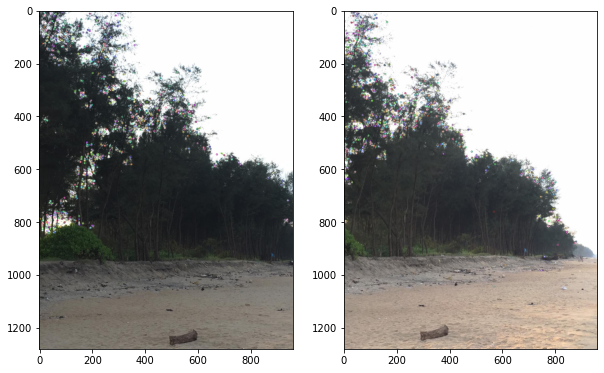

In [141]:
H = getH(im1,im2)

In [142]:
def new_image_dims(inImg, H):
  #get the shape of the input image in the mapped coordinates. 
  #get the image coordinates in world plane
  width=inImg.shape[0]-1
  height=inImg.shape[1]-1
  #print("width(x)=",width)
  #print("height(y)=",height)
  img_coords=np.array([[0,0,1],[0,height,1],[width,0,1],[width,height,1]])
  new_img_coords=np.zeros([4,2])
  for i in range(4):
    new_coords=np.matmul(H,img_coords[i])
    new_coords=new_coords/new_coords[2]
    new_coords=np.rint(new_coords).astype(int)
    new_img_coords[i,:]=new_coords[0:2]

  #print(new_img_coords)
  x_max = np.max(new_img_coords[:,0])
  y_max = np.max(new_img_coords[:,1])
  x_min = np.min(new_img_coords[:,0])
  y_min = np.min(new_img_coords[:,1])

  return [x_max, y_max, x_min, y_min]


In [143]:
def getImage(inImage,H,outImg,lims):
  # project all the points of images into an empty canvas.
  x_max,y_max,x_min,y_min = lims
  offsetX=x_min
  offsetY=y_min
  image=inImage
  world_image=outImg
  scaleFactor=1   # for faster working and controlling the image output size
  H_inv_=np.linalg.inv(H)
  for i in range(0,world_image.shape[1]-1): #X-cooridnate, col
        for j in range(0,world_image.shape[0]-1): #Y-coordinate, row
            k1 = i/scaleFactor + offsetX
            k2 = j/scaleFactor + offsetY
            X_domain = [k1,k2]
            X_domain = np.array(X_domain)
            X_domain = np.append(X_domain,1)
            X_range = np.matmul(H_inv_, X_domain)
            X_range = X_range/X_range[-1]
            X_range = np.rint(X_range)
            X_range = X_range.astype(int)
            if(X_range[0] > 0 and X_range[1] > 0 and X_range[0] < image.shape[1] and X_range[1] < image.shape[0]):
                world_image[j][i] = image[X_range[1]][X_range[0]]
                
  return world_image

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


'\nH1=getH(im1,im3)\nH2=getH(im2,im3)\nH3=np.eye(3)\nH4=getH(im4,im3)\nH5=getH(im5,im3)\n'

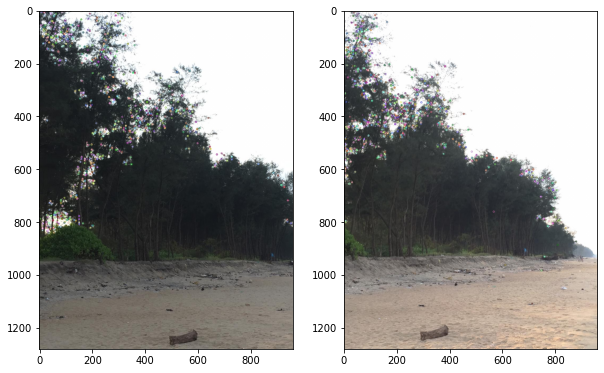

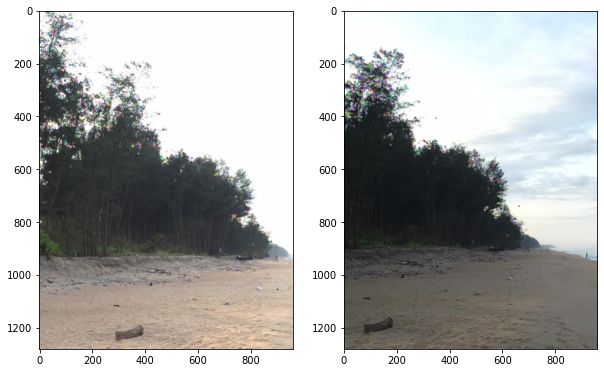

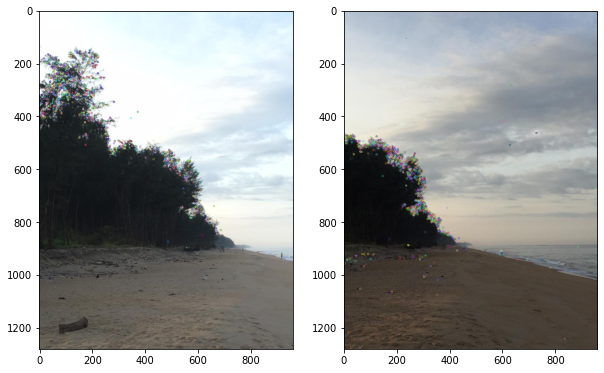

In [144]:
# Find the Homography of all the images with respect to the centre image.
'''
This is an iterative process as we will need to find the homographies between consequtive images and then combine them to get the
Homography between the image and the center image. This is necessary as directly finding the Homography might result in error as there
might not be any correspondences between the two images.
'''
H12 = getH(im1,im2)
H23 = getH(im2,im3)
H3 = np.eye(3)
H34 = getH(im3,im4)
#H45 = getH(im4,im5)

H1 = np.matmul(H12,H23)   #H13
H1 = H1/H1[-1,-1]

H2 = H23/H23[-1,-1]     #H23

H43 = np.linalg.inv(H34)
H4 = H43/H43[-1,-1]

'''
H35 = np.matmul(H34,H45)
H53 = np.linalg.inv(H35)
H5 = H53/H53[-1,-1]
'''

#################### 

# This is a try to get direct Homographies - regardless it fails 
'''
H1=getH(im1,im3)
H2=getH(im2,im3)
H3=np.eye(3)
H4=getH(im4,im3)
H5=getH(im5,im3)
'''

In [145]:
# get the new dimension of all the projected images
img1_lims = np.array(new_image_dims(im1, H1)).reshape(1,-1)
img2_lims = np.array(new_image_dims(im2, H2)).reshape(1,-1)
img3_lims = np.array(new_image_dims(im3, H3)).reshape(1,-1)
img4_lims = np.array(new_image_dims(im4, H4)).reshape(1,-1)
#img5_lims = np.array(new_image_dims(im5, H5)).reshape(1,-1)

[[ 877.  917. -435. -111.]
 [1074.  930. -224.  -60.]
 [1279.  959.    0.    0.]
 [1563.  993.  306.   45.]]
(1104, 1998, 3)
2nd
3rd
4th


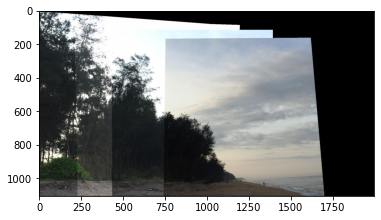

In [146]:
#lims = np.concatenate((img1_lims,img2_lims, img3_lims, img4_lims, img5_lims))
lims = np.concatenate((img1_lims,img2_lims, img3_lims, img4_lims))
x_max = np.max(lims[:,0]); y_max = np.max(lims[:,1])
x_min = np.min(lims[:,2]); y_min = np.min(lims[:,3])
print(lims)
blankImg = np.zeros((np.int(np.ceil(y_max-y_min)), np.int(np.ceil(x_max-x_min)),3), np.uint8)
print(blankImg.shape)

imgOut1 = getImage(im1,H1,blankImg,[x_max, y_max, x_min, y_min])
print("2nd")
imgOut1 = getImage(im2,H2,imgOut1,[x_max, y_max, x_min, y_min])
print("3rd")
imgOut1 = getImage(im3,H3,imgOut1,[x_max, y_max, x_min, y_min])
print("4th")
imgOut1 = getImage(im4,H4,imgOut1,[x_max, y_max, x_min, y_min])
#print("5th")
#imgOut1 = getImage(im5,H5,imgOut1,[x_max, y_max, x_min, y_min])

plt.imshow(imgOut1.astype(int))

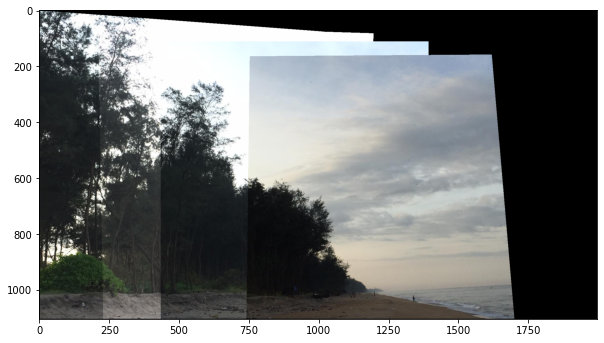

In [147]:
plt.figure(figsize=(10,10))
#plt.imshow(cv2.cvtColor(imgOut1,cv2.COLOR_BGR2RGB))
plt.imshow(imgOut1)

plt.imsave("launch_apts_pana.jpg",imgOut1)